In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import warnings
import logging
import platform
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)  # 设置 matplotlib 日志级别为 WARNING
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
# np.set_printoptions(threshold=np.inf, linewidth=200)

if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['Songti SC']
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['SimSun']
else:  # Linux
    plt.rcParams['font.family'] = ['Noto Sans CJK SC']
# matplotlib.rcParams['font.family']= ['Songti SC']  # 使用黑体-简
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

tf.config.threading.set_inter_op_parallelism_threads(16)
tf.config.threading.set_intra_op_parallelism_threads(16)

def create_sequneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

"""数据增强"""
def moving_average_smoothing(series, window_size=5):
    if series.ndim == 1:  # 处理一维情况
        series = series.reshape(-1, 1)
    smoothed_data = np.empty_like(series)  # 创建一个与原始数据形状相同的空数组
    for col in range(series.shape[1]):
        # 对每一列(每个特征)进行平滑处理
        smoothed_data[:,col] = np.convolve(series[:,col], np.ones(window_size)/window_size, mode='same')
    return smoothed_data

def random_noise(data, noise_factor=0.01):
    """随机噪声"""
    noise = noise_factor + np.random.randn(*data.shape)
    return data + noise

def time_series_shift(series, shift_range=5):
    """时间序列平移"""
    shift = np.random.randint(-shift_range, shift_range + 1)
    return np.roll(series, shift, axis=0)

def data_augmentation(X, y, num_augmentations=5):
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        # 移动平均平滑
        augmented_X.append(X[i])
        augmented_y.append(y[i])
        for _ in range(num_augmentations):
            # 增强方法1 平滑处理
            X_smooth = moving_average_smoothing(X[i])
            # 增加方法2 添加噪声
            X_noise = random_noise(X_smooth)
            # 增加方法3 时间偏移
            X_shift = time_series_shift(X_noise)
            augmented_X.append(X_shift)
            # 同步y增强（示例：添加噪声）
            y_smooth = moving_average_smoothing(y[i])
            y_noise = random_noise(y_smooth)
            y_shift = time_series_shift(y_noise)
            # y_noise = y[i] + np.random.normal(0, 0.01)  # 添加1%噪声
            augmented_y.append(y_shift)
    return np.array(augmented_X), np.array(augmented_y)

In [10]:
df = pd.read_csv('../data/train.csv', parse_dates=True)
df.tail()

,date,open,close,low,high,volume,count,amount,EMA20,EMA100,...,close_volatility,Volatility_10,close_Volume_volatility,Volume_volatility_10,UpperBB,MiddleBB,LowerBB,return_lag1,return_lag3,return_lag5
56037,2021-01-08 00:00:00,1249.68,1270.03,1238.63,1275.00,1.519157e+08,88764.0,120707.615800,1217.252295,1150.555278,...,0.016153,0.028735,2.453894e+06,2.586650e+06,1254.853740,1209.1415,1163.429260,0.016284,0.037844,0.042718
56038,2021-01-08 00:30:00,1270.03,1264.00,1256.54,1276.77,4.554146e+07,38376.0,35921.204872,1221.704458,1152.801708,...,-0.004759,0.030461,-2.167421e+05,2.671521e+06,1263.660887,1212.4120,1161.163113,-0.004748,0.035217,0.033575
56039,2021-01-08 01:00:00,1264.01,1271.01,1258.87,1272.67,2.763913e+07,25636.0,21843.700586,1226.400224,1155.142467,...,0.005531,0.029678,1.528600e+05,2.677215e+06,1272.765864,1216.1435,1159.521136,0.005546,0.017068,0.038644
56040,2021-01-08 01:30:00,1271.01,1270.57,1262.04,1273.71,1.671641e+07,18281.0,13184.631076,1230.606869,1157.428160,...,-0.000346,0.029463,-5.787913e+03,2.705898e+06,1279.915025,1220.3715,1160.827975,-0.000346,0.000425,0.040598
56041,2021-01-08 02:00:00,1270.56,1248.21,1227.17,1288.88,1.103349e+08,77906.0,87642.332626,1232.283358,1159.225821,...,-0.017755,0.036254,-1.959007e+06,3.561666e+06,1281.238661,1223.8910,1166.543339,-0.017598,-0.012492,-0.001176


In [11]:
target ='close'
features = df.drop(columns=['date', target]).values
X_origin = features.copy()
y_origin = df[target].copy().values.reshape(-1, 1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_origin)
y_train_scaled = scaler_y.fit_transform(y_origin)

划分数据集...
数据增强...
Origin traning data shape: (44785, 60, 30)
Augmented traning data shape: (268710, 60, 30)
交叉验证...
Fold 1
构建LSTM模型...
输入数据形状检查：(268650, 60, 30)


c:\Users\liufa\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


增加一层layer = 2, return_sequences=False


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,409 (224.25 KB)

 Trainable params: 57,409 (224.25 KB)

 Non-trainable params: 0 (0.00 B)

训练模型...
Epoch 1/20
700/700 - 51s - 73ms/step - loss: 0.3036 - mae: 0.0449 - val_loss: 0.1409 - val_mae: 0.0632
Epoch 2/20
700/700 - 37s - 53ms/step - loss: 0.0684 - mae: 0.0207 - val_loss: 0.0307 - val_mae: 0.0496
Epoch 3/20
700/700 - 40s - 57ms/step - loss: 0.0133 - mae: 0.0167 - val_loss: 0.0081 - val_mae: 0.0458
Epoch 4/20
700/700 - 39s - 55ms/step - loss: 0.0033 - mae: 0.0149 - val_loss: 0.0044 - val_mae: 0.0433
Epoch 5/20
700/700 - 37s - 53ms/step - loss: 0.0016 - mae: 0.0145 - val_loss: 0.0035 - val_mae: 0.0442
Epoch 6/20
700/700 - 35s - 50ms/step - loss: 0.0011 - mae: 0.0136 - val_loss: 0.0031 - val_mae: 0.0428
Epoch 7/20
700/700 - 35s - 50ms/step - loss: 8.2395e-04 - mae: 0.0131 - val_loss: 0.0033 - val_mae: 0.0449
Epoch 8/20
700/700 - 39s - 55ms/step - loss: 6.8502e-04 - mae: 0.0126 - val_loss: 0.0028 - val_mae: 0.0432
Epoch 9/20
700/700 - 35s - 51ms/step - loss: 6.1463e-04 - mae: 0.0125 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 10/20
700/700 - 31s - 44ms/step - loss: 5.7242e

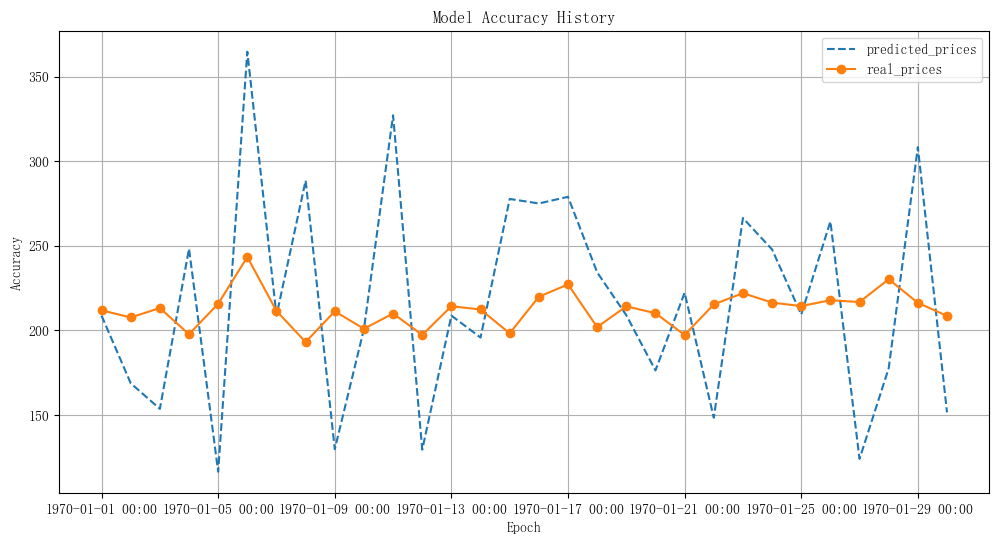

Fold 2
构建LSTM模型...
输入数据形状检查：(268680, 60, 30)


c:\Users\liufa\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


增加一层layer = 2, return_sequences=False


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,409 (224.25 KB)

 Trainable params: 57,409 (224.25 KB)

 Non-trainable params: 0 (0.00 B)

训练模型...
Epoch 1/20
700/700 - 40s - 57ms/step - loss: 0.3064 - mae: 0.0468 - val_loss: 0.1433 - val_mae: 0.0592
Epoch 2/20
700/700 - 31s - 45ms/step - loss: 0.0697 - mae: 0.0218 - val_loss: 0.0320 - val_mae: 0.0538
Epoch 3/20
700/700 - 31s - 45ms/step - loss: 0.0137 - mae: 0.0168 - val_loss: 0.0092 - val_mae: 0.0486
Epoch 4/20
700/700 - 31s - 45ms/step - loss: 0.0035 - mae: 0.0149 - val_loss: 0.0051 - val_mae: 0.0464
Epoch 5/20
700/700 - 32s - 45ms/step - loss: 0.0017 - mae: 0.0142 - val_loss: 0.0041 - val_mae: 0.0462
Epoch 6/20
700/700 - 34s - 49ms/step - loss: 0.0011 - mae: 0.0135 - val_loss: 0.0036 - val_mae: 0.0448
Epoch 7/20
700/700 - 33s - 48ms/step - loss: 8.6669e-04 - mae: 0.0128 - val_loss: 0.0033 - val_mae: 0.0458
Epoch 8/20
700/700 - 31s - 45ms/step - loss: 7.2630e-04 - mae: 0.0126 - val_loss: 0.0031 - val_mae: 0.0440
Epoch 9/20
700/700 - 36s - 52ms/step - loss: 6.4968e-04 - mae: 0.0122 - val_loss: 0.0032 - val_mae: 0.0441
Epoch 10/20
700/700 - 40s - 57ms/step - loss: 5.8797e

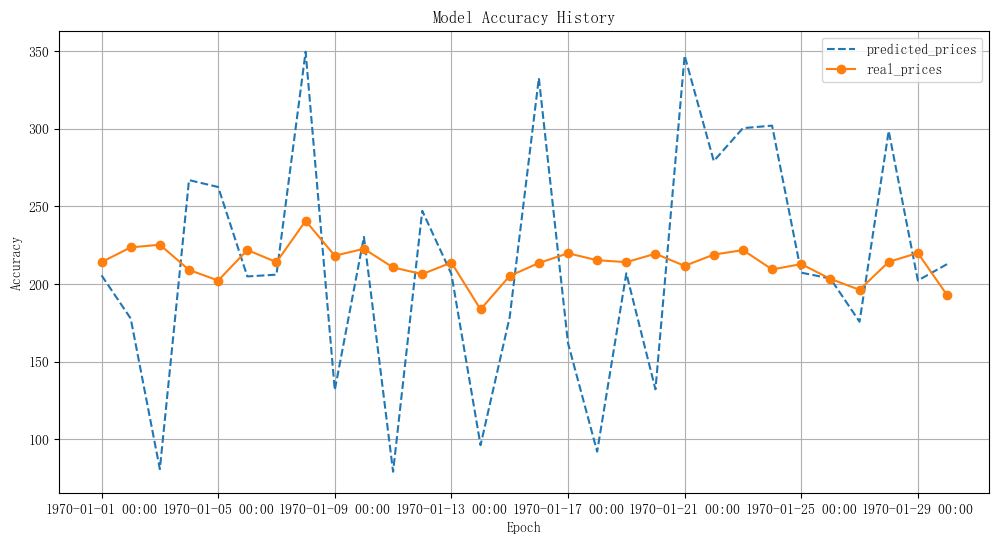

交叉验证结果：{'MSE': [3809.6209776559726, 5416.922646329351], 'RMSE': [np.float64(61.7221271316533), np.float64(73.59974623821302)], 'MAE': [51.06305298257421, 58.27463247107421], 'R2': [-33.73852309406212, -47.0368683206305]}


In [12]:
"""
将时间序列数据划分为多个窗口，每个窗口包含过去window_size个时间步的数据和下一个时间步的标签。
"""
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
window_sizes = [10, 30, 60, 90, 120]
lstm_params={"layers":2, 'units': 64,  'dropout_rate': 0.3, 'learning_rate': 0.0001, 'clipvalue': 0.5, 'epochs': 20,'batch_size': 64, 'input_window': 60}
layers = lstm_params.get('layers')
model_name=f"Cross-LSTM-w{lstm_params.get('input_window')}-layers{layers}-u{lstm_params.get('units')}-d{lstm_params.get('dropout_rate')}-l{lstm_params.get('learning_rate')}-c{lstm_params.get('clipvalue')}-e{lstm_params.get('epochs')}-b{lstm_params.get('batch_size')}"

print("划分数据集...")
X_train_full, y_train_full = create_sequneces(X_train_scaled, y_train_scaled, lstm_params.get('input_window'))
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=False)

print("数据增强...")
print(f"Origin traning data shape: {X_train.shape}")
X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train, y_train)
print(f"Augmented traning data shape: {X_train_full_augmented.shape}")
print("交叉验证...")
tscv = TimeSeriesSplit(n_splits=2, test_size=30)
result = {metric: [] for metric in metrics}
for fold,(train_index, val_index) in enumerate(tscv.split(X_train_full_augmented)):
    print(f"Fold {fold+1}")
    X_train_fold, X_val_fold = X_train_full_augmented[train_index], X_train_full_augmented[val_index]
    y_train_fold, y_val_fold = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

    print("构建LSTM模型...")
    print(f"输入数据形状检查：{X_train_fold.shape}")  # 应为 (样本数, 时间步, 特征数)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=lstm_params.get('units'), 
                                input_shape=( X_train_fold.shape[1], X_train_fold.shape[2]), return_sequences=layers > 1, 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(lstm_params.get('dropout_rate')))
    for i in range(1, lstm_params.get('layers')):
        print(f"增加一层layer = {i+1}, return_sequences={layers -1 > i}")
        model.add(tf.keras.layers.LSTM(units=lstm_params.get('units'), return_sequences=(layers -1 > i)))
        model.add(tf.keras.layers.Dropout(lstm_params.get('dropout_rate')))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lstm_params.get('learning_rate'),
                                                    clipvalue=lstm_params.get('clipvalue')), loss='mean_squared_error', metrics=['mae'])
    model.summary()

    print("训练模型...")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=lstm_params.get('epochs'), 
                        batch_size=lstm_params.get('batch_size'), 
                        validation_data=(X_val_fold, y_val_fold), verbose=2, callbacks=[early_stopping])
    
    print("预测模型...")
    predictions = model.predict(X_val_fold)
    predicted_prices =  scaler_y.inverse_transform(predictions)
    real_prices = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1))
    # 在预测阶段使用原始y值
    real_raw_prices = scaler_y.inverse_transform(
        y_train_scaled[-len(predicted_prices):].reshape(-1,1)
    )
    print("=================================================================")
   # 更直观的对比方式
    comparison_df = pd.DataFrame({
        'date':df['date'].iloc[-len(real_prices):].values,
        'Predicted': predicted_prices.ravel(),
        'Actual_Processed Price': real_prices.ravel(), # 数据增强处理后的实际值
        'Origin Price': real_raw_prices[-len(real_prices):].ravel() # 原始数据
    })
    print("\\n最后10条价格对比:")
    print(comparison_df.tail(10).to_markdown(floatfmt=".2f"))
    print("=================================================================")
    """模型验证和评估"""
    print("评估模型...")
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)
    result['MSE'].append(mse)
    result['RMSE'].append(rmse)
    result['MAE'].append(mae)
    result['R2'].append(r2)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")

    # # 打印结果
    fig, (ax) = plt.subplots(1,1,figsize=(12, 6))
    plt.plot(comparison_df['date'],predicted_prices, label='predicted_prices', linestyle='--')
    plt.plot(comparison_df['date'],real_prices, label='real_prices', marker='o')
    plt.title('Model Accuracy History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.grid(True)
    fig.savefig(f'results/model_predicted_prices-{model_name}.png')
    plt.show()

    # fig2, (ax2) = plt.subplots(1,1,figsize=(12, 6))
    # plt.plot(predicted_prices[-100:], label='predicted_prices')
    # plt.plot(real_prices[-100:], label='real_prices')
    # ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    # ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    # plt.title('Model Accuracy History')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


    # """打印验证损失曲线"""
    # fig2 = plt.figure(figsize=(16, 6))
    # plt.plot(history.history['loss'], label='Training Loss')
    # # 绘制验证损失曲线（如果有验证集）
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # # 添加统计信息框
    # stats_text = f"""模型验证和评估：
    # • Mean Squared Error (MSE):{mse}
    # • Root Mean Squared Error (RMSE):{rmse}
    # • Mean Absolute Error (MAE):{mae}
    # • R-squared (R2): {r2}
    # """

    # plt.annotate(stats_text, 
    #             xy=(0.78, 0.85), 
    #             xycoords='axes fraction',
    #             bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    # plt.title(f'Model Training History')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend()
    # plt.grid(True)
    # fig2.savefig(f'results/model_loss-{model_name}.png')
    # plt.show()

print(f"交叉验证结果：{result}")